In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd
from torchvision.utils import make_grid
from torch.optim import Adam,AdamW
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import functools
import time
from torchdiffeq import odeint_adjoint,odeint
import os


from network_class import *
from utils import *


In [2]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def grad_log_Gaussian(x):
    return -x


def divergence_bf(dx, y):
    sum_diag = 0.
    for i in range(y.shape[1]):
        sum_diag += torch.autograd.grad(dx[:, i].sum(), y, create_graph=True)[0].contiguous()[:, i].contiguous()
    return sum_diag.contiguous()

def jac_div_graddivf(dx, y):
    jacobian=[]
    divergence= 0.
    for i in range(y.shape[1]):
        jacobian_i = torch.autograd.grad(dx[:,i].sum(), y, create_graph=True,retain_graph=True)[0].contiguous()
        divergence += jacobian_i[:, i].contiguous()
        jacobian.append(jacobian_i)
    stacked_jacobbian = torch.stack(jacobian, dim=2)
    grad_div_f=torch.autograd.grad(divergence.sum(), y, create_graph=True,retain_graph=True)[0]
    return stacked_jacobbian.contiguous(),divergence.contiguous().view(y.shape[0],1),grad_div_f

class ODE_forward(nn.Module):
    def __init__(self, net):
        super(ODE_forward, self).__init__()
        self.f_theta = net
    def forward(self, t, states):
        x = states[0]
        with torch.set_grad_enabled(True):
            x.requires_grad_(True)
            t.requires_grad_(True)

            dy = self.f_theta(t, x)
            divergence = divergence_bf(dy, x)

        divergence = divergence.contiguous().view(x.shape[0],1)

        return tuple([dy, -divergence])


class ODE_backward(nn.Module):
    def __init__(self, net):
        super(ODE_backward, self).__init__()
        self.f_theta = net
    def forward(self, t, states):
        x = states[0]
        score=states[1]
        with torch.set_grad_enabled(True):
            x.requires_grad_(True)
            t.requires_grad_(True)
            dy = self.f_theta(t, x)
            stacked_jacobbian,_,grad_div_f= jac_div_graddivf(dy, x)
        J_mul_f=torch.bmm(stacked_jacobbian,score.unsqueeze(2)).squeeze()
        d_score=(-grad_div_f-J_mul_f)
        d_penalty=torch.mean(torch.sum((dy+score)**2,dim=1)).to(device)*0.5

        return tuple([dy, d_score,d_penalty])

def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z_temp = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp =z_temp+ (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp = z_temp+(2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z_temp = z_temp+(1.0/6.0) * K
    return z_temp  

def odefun(x, t, net):
    dx = net(t,x)
    return dx


def odefun_backward(cat_var, t, net):
    d=net.d
    x=cat_var[:,0:d]
    score=cat_var[:,d+1:-1]
    divergence_f=torch.zeros(x.shape[0],device=device)
    
    f=net(t, x).reshape(x.shape[0],-1)

    jacobian = []
    for i in range(d):
        jacobian_i = autograd.grad(f[:,i].sum(), x, create_graph=True,retain_graph=True,)[0]
        jacobian.append(jacobian_i)
    stacked_jacobbian = torch.stack(jacobian, dim=2)
    divergence_f = torch.diagonal(stacked_jacobbian, dim1=-2, dim2=-1).sum(-1).reshape(-1,1)

    d_log=-divergence_f.reshape(-1,1)
    #calculate jacobbian 
    grad_div_f=autograd.grad(divergence_f.sum(), x, create_graph=True,retain_graph=True)[0]
    # stacked_jacobbian_transpose = torch.transpose(stacked_jacobbian, 1, 2)
    J_mul_f=torch.bmm(stacked_jacobbian,score.unsqueeze(2)).squeeze()
    d_score=(-grad_div_f-J_mul_f)
    d_penalty=torch.mean(torch.sum((f+score)**2,dim=1))*torch.ones(x.shape[0],1).to(device)*0.5

    return torch.cat((f,d_log,d_score,d_penalty),dim=1)


In [3]:

device = 'cuda:2' #@param ['cuda', 'cpu'] {'type':'string'}

n_epochs =  800#@param {'type':'integer'}
batch_size =  1000 #@param {'type':'integer'}
lr=4e-2 #@param {'type':'number'}
tspan=[0,1]
d=2

data_name="8gaussians"  # "moon" "checkerboard" "circles" "8gaussians"
experiment_path="experiment/"+data_name
experiment_pic_path=experiment_path+"/pic/"
if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
        os.makedirs(experiment_pic_path)

f_theta = ODEnet(d=2)
ODE_forward=ODE_forward(f_theta).to(device)
ODE_backward=ODE_backward(f_theta).to(device)
count_parameters(ODE_forward)
optim = AdamW(ODE_forward.parameters(), lr=lr,weight_decay=1e-5)





total parameter is:  9224


In [ ]:

llh_record=[]
v_pen_record=[]
tqdm_epoch = tqdm.trange(n_epochs)

for epoch in tqdm_epoch:
    
    #resample
    if epoch%1==0:
        x=torch.tensor(generate_2d(batch_size=batch_size,data_name=data_name)).float()
        x = x.to(device)
         
    _logpz = torch.zeros(x.shape[0], 1).to(x)

    integration_times = torch.tensor([0.0, 1.]).float().to(device)
    state_t = odeint(
                ODE_forward,
                (x,_logpz),
                integration_times,
                atol=1e-5,
                rtol=1e-5,
                method="dopri5"
            )
    z_terminal,delta_log=tuple(s[1] for s in state_t)  #delta_log = \int -trace
    log_terminal=log_Gaussian(x=z_terminal,d=d)
    likelihood=torch.mean(log_terminal)-delta_log.mean()
    score_terminal=grad_log_Gaussian(x=z_terminal)
    

    _bridge_penalty = torch.zeros(1).squeeze().to(x)
    # reverse_times = torch.tensor([1.0, 0.0]).float().to(device)
    reverse_times=torch.arange(1.,0., -0.05).float().to(device)
    state_t = odeint(
                ODE_backward,
                (z_terminal,score_terminal,_bridge_penalty),
                reverse_times,
                method="euler"
            )
    _,_,_bridge_penalty=tuple(s[-1] for s in state_t)  #delta_log = \int -trace
    bridge_penalty=-_bridge_penalty


    # bridge_penalty=torch.zeros(likelihood.shape).to(likelihood)
    loss=-likelihood*10  + bridge_penalty
    optim.zero_grad()
    loss.backward()
    optim.step()
    llh_record.append(-likelihood.detach().cpu())
    v_pen_record.append(bridge_penalty.detach().cpu())
    tqdm_epoch.set_description('nll: {:4f} Bridge: {:4f}  '.format(-likelihood.detach().cpu(),bridge_penalty.detach().cpu()))
    # tqdm_epoch.set_description('nll: {:5f}  '.format(-likelihood.detach().cpu()))

    if (epoch+1) % 10== 0:  ##Viz
        torch.save(f_theta.state_dict(), f'experiment/{data_name}/{data_name}_2d.pth')

        #forward process
        x=torch.tensor(generate_2d(batch_size=10000,data_name=data_name)).float().to(device)
        integration_times = torch.linspace(0,1,8).to(device)
        state_t_forward = odeint(f_theta,x,integration_times,atol=1e-5,rtol=1e-5,method="dopri5")

        x=torch.randn(10000,2).to(device)
        integration_times = torch.linspace(1,0,8).to(device)
        state_t_backward = odeint(f_theta,x,integration_times,atol=1e-5,rtol=1e-5,method="dopri5")

        plot_z_state(state_t_forward,state_t_backward,save_path='experiment/'+data_name+'/pic/Forward_backward.png')

        x=torch.randn(10000,2).to(device)
        integration_times = torch.linspace(1,0,21).to(device)
        state_t = odeint(f_theta,x,integration_times,atol=1e-5,rtol=1e-5,method="dopri5")
        plot_ode_trajectory(state_t,save_path='experiment/'+data_name+'/pic/trajectories.png')
        






  0%|          | 0/800 [00:00<?, ?it/s]

nll: 2.901847 Bridge: 0.000000  :  25%|██▌       | 202/800 [04:17<12:43,  1.28s/it]


KeyboardInterrupt: 

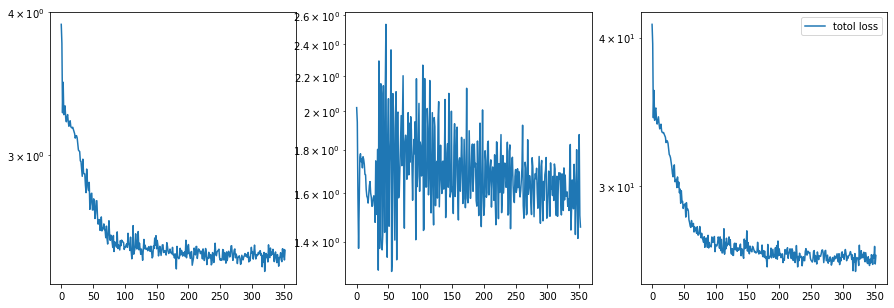

tensor(1.4574)


In [ ]:

# plot_loss(llh_record)
plot_loss_all(llh_record,v_pen_record)
print(v_pen_record[-1])
